# How to identify gentrified areas?

1. measure both housing price increases and changes in deprivation levels. 
2. calculate the **percentage increase** in average housing prices for each area over the five-year period
3. use the IMD to assess whether the area's deprivation level has improved—measured by a drop in IMD decile scores

Areas where **both** house prices and IMD scores rose faster than average are flagged as likely to be experiencing gentrification.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [2]:
import sys
print(sys.executable)

e:\dissertation\project\housing_feature_gentrification\venv\Scripts\python.exe


## House price

In [3]:
# reading house price
house_path = "data/gentri_data/HPSSA_Dataset_46_Median_price_paid_for_residential_properties_by_LSOA.xls"
house_price = pd.ExcelFile(house_path)

In [4]:
# reading sheet
df_house = house_price.parse(sheet_name="1a", header = 5) 
df_house.head()

,Local authority code,Local authority name,LSOA code,LSOA name,Year ending Dec 1995,Year ending Mar 1996,Year ending Jun 1996,Year ending Sep 1996,Year ending Dec 1996,Year ending Mar 1997,...,Year ending Dec 2020,Year ending Mar 2021,Year ending Jun 2021,Year ending Sep 2021,Year ending Dec 2021,Year ending Mar 2022,Year ending Jun 2022,Year ending Sep 2022,Year ending Dec 2022,Year ending Mar 2023
0,E06000001,Hartlepool,E01011949,Hartlepool 009A,34750,34500,30500,30000,29950,29000,...,88000,81500,80500,89000,101500,94500,113000,97500,102500,106500
1,E06000001,Hartlepool,E01011950,Hartlepool 008A,25000,25000,25300,25625,25000,24800,...,29750,33000,47000,49999,50159,50159,46000,43500,42000,43500
2,E06000001,Hartlepool,E01011951,Hartlepool 007A,27000,27000,27250,28950,28500,28950,...,50000,51500,53000,58573.5,60000,62999,61499.5,60000,65499.5,66000
3,E06000001,Hartlepool,E01011952,Hartlepool 002A,44500,44500,30000,26675,26000,25500,...,85000,:,83500,83000,80000,76000,75000,75000,70000,60000
4,E06000001,Hartlepool,E01011953,Hartlepool 002B,22000,27000,27000,20600,20000,19500,...,:,:,:,95000,92500,95000,95000,92500,93750,92500


In [5]:
# select the column that's needed
house_columns_needed = ['LSOA code', 'LSOA name', 
                        'Year ending Dec 2015', 'Year ending Sep 2015', 'Year ending Jun 2015', 'Year ending Mar 2015',
                        'Year ending Dec 2019', 'Year ending Sep 2019', 'Year ending Jun 2019', 'Year ending Mar 2019'] 
df_house_select = df_house[house_columns_needed]
df_house_select.head()

,LSOA code,LSOA name,Year ending Dec 2015,Year ending Sep 2015,Year ending Jun 2015,Year ending Mar 2015,Year ending Dec 2019,Year ending Sep 2019,Year ending Jun 2019,Year ending Mar 2019
0,E01011949,Hartlepool 009A,73000,77000,68500,69000,77000,77500,77500,73250
1,E01011950,Hartlepool 008A,29400,29150,29000,29250,27500,27000,29500,28000
2,E01011951,Hartlepool 007A,46000,50000,56500,50500,39997.5,42800,46250,50000
3,E01011952,Hartlepool 002A,63747.5,63747.5,51000,56750,66475,70000,70000,70000
4,E01011953,Hartlepool 002B,65000,60500,61000,60000,58000,62000,59000,66000


In [6]:
# read in lsoa shapefile
london_gdf = gpd.read_file("data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")

# extract lsoa11cd as LSOA list
london_lsoa_list = london_gdf['LSOA11CD'].unique()

In [7]:
# select data in London area
df_london_price = df_house_select[df_house_select['LSOA code'].isin(london_lsoa_list)]
df_london_price.dtypes

LSOA code               object
LSOA name               object
Year ending Dec 2015    object
Year ending Sep 2015    object
Year ending Jun 2015    object
Year ending Mar 2015    object
Year ending Dec 2019    object
Year ending Sep 2019    object
Year ending Jun 2019    object
Year ending Mar 2019    object
dtype: object

In [8]:
# turn object into float
columns_to_convert = [
    'Year ending Mar 2015', 'Year ending Jun 2015',
    'Year ending Sep 2015', 'Year ending Dec 2015',
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019'
]

df_london_price[columns_to_convert] = (df_london_price[columns_to_convert].apply(pd.to_numeric, errors='coerce'))

C:\Users\hp\AppData\Local\Temp\ipykernel_36284\3000649747.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price[columns_to_convert] = (df_london_price[columns_to_convert].apply(pd.to_numeric, errors='coerce'))


In [9]:
# calculating the mean of 2015 and 2019
df_london_price['2015'] = df_london_price[[
    'Year ending Mar 2015', 'Year ending Jun 2015',
    'Year ending Sep 2015', 'Year ending Dec 2015'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price['2019'] = df_london_price[[
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_36284\335151379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price['2015'] = df_london_price[[
C:\Users\hp\AppData\Local\Temp\ipykernel_36284\335151379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price['2019'] = df_london_price[[


In [10]:
# calculating the chage(Relative Growth Rate) percentage between 2015 to 2019
df_london_price.loc[:, 'price_growth'] = (df_london_price['2019'] - df_london_price['2015']) / df_london_price['2015']
df_london_price.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_36284\1424116064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price.loc[:, 'price_growth'] = (df_london_price['2019'] - df_london_price['2015']) / df_london_price['2015']


,LSOA code,LSOA name,Year ending Dec 2015,Year ending Sep 2015,Year ending Jun 2015,Year ending Mar 2015,Year ending Dec 2019,Year ending Sep 2019,Year ending Jun 2019,Year ending Mar 2019,2015,2019,price_growth
28009,E01000001,City of London 001A,872500.0,870000.0,907500.0,883000.0,865000.0,887500.0,847500.0,815000.0,883250.00,853750.00,-0.033399
28010,E01000002,City of London 001B,844525.0,800000.0,765000.0,735520.0,862500.0,880000.0,857500.0,835000.0,786261.25,858750.00,0.092194
28011,E01000003,City of London 001C,525000.0,500000.0,520000.0,520000.0,515000.0,572500.0,599000.0,599500.0,516250.00,571500.00,0.107022
28012,E01000005,City of London 001E,510000.0,430000.0,372500.0,399000.0,NaN,NaN,NaN,NaN,427875.00,NaN,NaN
28013,E01032739,City of London 001F,785000.0,835350.0,818200.0,835000.0,1500000.0,996075.0,941160.0,964500.0,818387.50,1100433.75,0.344637


### ! Important
price dataset has missing data

In [11]:
df_london_price.isna().sum()

LSOA code                 0
LSOA name                 0
Year ending Dec 2015    120
Year ending Sep 2015    122
Year ending Jun 2015    102
Year ending Mar 2015    116
Year ending Dec 2019    416
Year ending Sep 2019    437
Year ending Jun 2019    412
Year ending Mar 2019    396
2015                     55
2019                    204
price_growth            226
dtype: int64

In [12]:
# delete all the na data
df_house_price_cleaned = df_london_price.dropna(subset=['2015', '2019', 'price_growth'])
df_house_price_cleaned.shape

(4609, 13)

## IMD

- imd score: the larger the score, the more deprived the area (and the lower its rank)

- imd rank: the lower the rank, the more deprived the area

the rank is not isometric, one rank between different lsoas may not be the same, so i think it‘s better to use scores to calculate the rate

In [13]:
# read in imd data
# 2019
imd_2019 = pd.ExcelFile("data/gentri_data/File_5_-_IoD2019_Scores.xlsx")
df_imd_2019 = imd_2019.parse(sheet_name="IoD2019 Scores") 
df_imd_2019.head()

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Income Score (rate),Employment Score (rate),"Education, Skills and Training Score",Health Deprivation and Disability Score,Crime Score,Barriers to Housing and Services Score,Living Environment Score,Income Deprivation Affecting Children Index (IDACI) Score (rate),Income Deprivation Affecting Older People (IDAOPI) Score (rate),Children and Young People Sub-domain Score,Adult Skills Sub-domain Score,Geographical Barriers Sub-domain Score,Wider Barriers Sub-domain Score,Indoors Sub-domain Score,Outdoors Sub-domain Score
0,E01000001,City of London 001A,E09000001,City of London,6.208,0.007,0.010,0.024,-1.654,-2.012,29.472,31.873,0.006,0.012,-2.107,0.032,-0.430,3.587,0.006,1.503
1,E01000002,City of London 001B,E09000001,City of London,5.143,0.034,0.027,0.063,-1.115,-2.343,24.412,23.084,0.037,0.030,-1.907,0.034,-1.060,3.231,-0.410,1.196
2,E01000003,City of London 001C,E09000001,City of London,19.402,0.086,0.086,5.804,-0.102,-1.032,40.103,40.535,0.052,0.128,-0.292,0.142,-0.691,5.173,-0.054,2.207
3,E01000005,City of London 001E,E09000001,City of London,28.652,0.211,0.136,22.260,-0.121,-1.317,39.900,28.979,0.209,0.322,0.338,0.321,-1.167,5.361,-0.604,1.769
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,19.837,0.117,0.059,14.798,-0.359,-0.147,45.171,26.888,0.155,0.162,-0.366,0.325,-0.400,5.590,0.110,0.969


In [14]:
# select *Index of Multiple Deprivation (IMD) Score* in London area
df_imd_2019_only = df_imd_2019[['LSOA code (2011)', 'LSOA name (2011)', 'Index of Multiple Deprivation (IMD) Score']]
df_imd_2019_only.head()

,LSOA code (2011),LSOA name (2011),Index of Multiple Deprivation (IMD) Score
0,E01000001,City of London 001A,6.208
1,E01000002,City of London 001B,5.143
2,E01000003,City of London 001C,19.402
3,E01000005,City of London 001E,28.652
4,E01000006,Barking and Dagenham 016A,19.837


In [15]:
df_london_imd_2019 = df_imd_2019_only[df_imd_2019_only['LSOA code (2011)'].isin(london_lsoa_list)]
df_london_imd_2019.shape

(4835, 3)

In [16]:
#2015
imd_2015 = pd.ExcelFile("data/gentri_data/File_5_ID_2015_Scores_for_the_Indices_of_Deprivation.xlsx")
df_imd_2015 = imd_2015.parse(sheet_name="ID2015 Scores") 
df_imd_2015.head()

,LSOA code (2011),LSOA name (2011),Local Authority District code (2013),Local Authority District name (2013),Index of Multiple Deprivation (IMD) Score,Income Score (rate),Employment Score (rate),"Education, Skills and Training Score",Health Deprivation and Disability Score,Crime Score,Barriers to Housing and Services Score,Living Environment Score,Income Deprivation Affecting Children Index (IDACI) Score (rate),Income Deprivation Affecting Older People (IDAOPI) Score (rate),Children and Young People Sub-domain Score,Adult Skills Sub-domain Score,Geographical Barriers Sub-domain Score,Wider Barriers Sub-domain Score,Indoors Sub-domain Score,Outdoors Sub-domain Score
0,E01031349,Adur 001A,E07000223,Adur,12.389,0.096,0.083,20.055,-0.718,0.242,10.586,15.180,0.143,0.103,0.098,0.333,-0.346,-0.721,-0.268,0.312
1,E01031350,Adur 001B,E07000223,Adur,28.619,0.187,0.162,34.653,0.722,0.244,24.689,17.837,0.211,0.269,0.470,0.426,0.234,1.104,0.016,0.234
2,E01031351,Adur 001C,E07000223,Adur,11.713,0.065,0.066,26.334,-0.616,0.495,13.631,11.150,0.077,0.079,0.395,0.357,0.035,-1.048,-0.628,0.208
3,E01031352,Adur 001D,E07000223,Adur,16.446,0.117,0.113,25.779,-0.234,0.026,17.803,10.677,0.210,0.087,0.348,0.359,0.233,-0.596,-0.576,0.109
4,E01031370,Adur 001E,E07000223,Adur,18.265,0.102,0.115,32.056,0.082,0.182,15.482,15.378,0.117,0.131,0.840,0.338,-0.083,-0.086,-0.256,0.321


In [17]:
df_imd_2015_only = df_imd_2015[['LSOA code (2011)', 'Index of Multiple Deprivation (IMD) Score']]
df_imd_2015_only.head()

,LSOA code (2011),Index of Multiple Deprivation (IMD) Score
0,E01031349,12.389
1,E01031350,28.619
2,E01031351,11.713
3,E01031352,16.446
4,E01031370,18.265


In [18]:
df_london_imd_2015 = df_imd_2015_only[df_imd_2015_only['LSOA code (2011)'].isin(london_lsoa_list)]
df_london_imd_2015.shape

(4835, 2)

In [19]:
# merge two dataframe
df_london_imd = pd.merge(
    df_london_imd_2015,
    df_london_imd_2019,
    on='LSOA code (2011)',
    suffixes=('_2015', '_2019')
)

As the larger imd score means more deprived area is, we need to calculate the decrese between 2015 -2019 to represent the increase of the area. S here I use the date of 2015 to minus 2019.

In [20]:
# calculate improving rate
df_london_imd['imd_score_improve'] = (
    df_london_imd['Index of Multiple Deprivation (IMD) Score_2015'] - 
    df_london_imd['Index of Multiple Deprivation (IMD) Score_2019']
) / df_london_imd['Index of Multiple Deprivation (IMD) Score_2015']

df_london_imd.head()

,LSOA code (2011),Index of Multiple Deprivation (IMD) Score_2015,LSOA name (2011),Index of Multiple Deprivation (IMD) Score_2019,imd_score_improve
0,E01000027,41.997,Barking and Dagenham 001A,37.347,0.110722
1,E01000028,43.130,Barking and Dagenham 001B,40.078,0.070763
2,E01000029,26.669,Barking and Dagenham 001C,22.503,0.156211
3,E01000030,41.284,Barking and Dagenham 001D,38.415,0.069494
4,E01000031,25.078,Barking and Dagenham 002A,22.672,0.095941


## Gentrified areas

In [21]:
df_london_imd.rename(columns={'LSOA code (2011)': 'LSOA code'}, inplace=True)

In [22]:
df_london_all = pd.merge(
    df_house_price_cleaned,
    df_london_imd,
    on='LSOA code',
    how='inner'  # only keep the lsoa that have both data
)

In [23]:
# calculate the averages
mean_price_growth = df_london_all['price_growth'].mean()
mean_imd_improve = df_london_all['imd_score_improve'].mean()

In [24]:
# add labels
df_london_all['high_price_growth'] = df_london_all['price_growth'] > mean_price_growth
df_london_all['high_imd_improvement'] = df_london_all['imd_score_improve'] > mean_imd_improve

df_london_all.head()

,LSOA code,LSOA name,Year ending Dec 2015,Year ending Sep 2015,Year ending Jun 2015,Year ending Mar 2015,Year ending Dec 2019,Year ending Sep 2019,Year ending Jun 2019,Year ending Mar 2019,2015,2019,price_growth,Index of Multiple Deprivation (IMD) Score_2015,LSOA name (2011),Index of Multiple Deprivation (IMD) Score_2019,imd_score_improve,high_price_growth,high_imd_improvement
0,E01000001,City of London 001A,872500.0,870000.0,907500.0,883000.0,865000.0,887500.0,847500.0,815000.0,883250.00,853750.00,-0.033399,6.063,City of London 001A,6.208,-0.023916,False,False
1,E01000002,City of London 001B,844525.0,800000.0,765000.0,735520.0,862500.0,880000.0,857500.0,835000.0,786261.25,858750.00,0.092194,6.255,City of London 001B,5.143,0.177778,False,True
2,E01000003,City of London 001C,525000.0,500000.0,520000.0,520000.0,515000.0,572500.0,599000.0,599500.0,516250.00,571500.00,0.107022,19.548,City of London 001C,19.402,0.007469,False,False
3,E01032739,City of London 001F,785000.0,835350.0,818200.0,835000.0,1500000.0,996075.0,941160.0,964500.0,818387.50,1100433.75,0.344637,13.169,City of London 001F,13.584,-0.031513,True,False
4,E01032740,City of London 001G,885000.0,911750.0,880000.0,880000.0,874000.0,1054000.0,1357250.0,1277750.0,889187.50,1140750.00,0.282913,14.780,City of London 001G,15.841,-0.071786,True,False


In [25]:
# identify gentrification
df_london_all['gentrified'] = df_london_all['high_price_growth'] & df_london_all['high_imd_improvement']
df_london_all['gentrified'].value_counts()

gentrified
False    3456
True     1153
Name: count, dtype: int64

In [26]:
# save a copy
df_london_all.to_csv("data/london_gentrification_analysis.csv", index=False)

In [27]:
# plot maps
# change the column name in shp
london_gdf.rename(columns={'LSOA11CD': 'LSOA code'}, inplace=True)

In [28]:
# merge data with shp
london_gdf_merged = london_gdf.merge(df_london_all, on='LSOA code', how='inner')

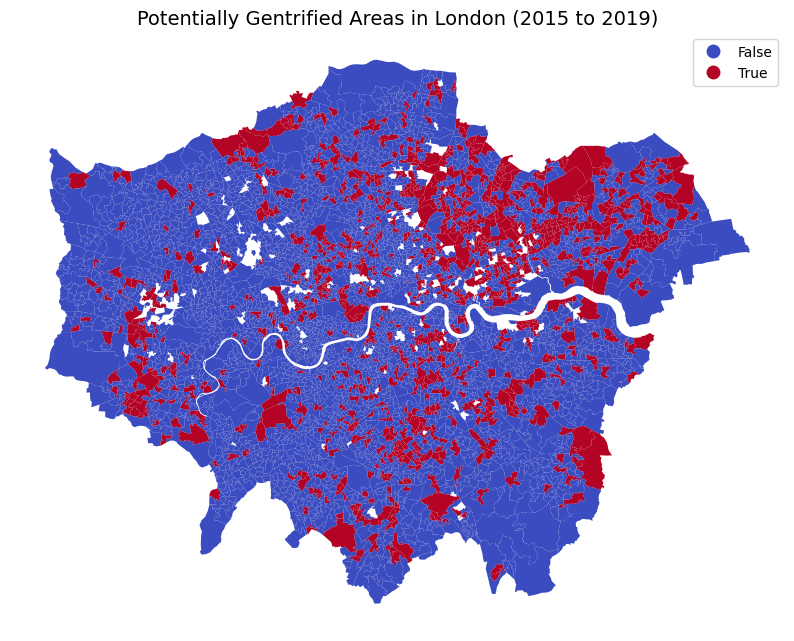

In [29]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_gdf_merged.plot(column='gentrified', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Potentially Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

Gentrification appears to be spatially scattered, with clusters emerging in **parts of Inner East and South London** — particularly in boroughs such as Hackney, Southwark, and Newham. 

However, the dispersed nature of red zones suggests that gentrification may be occurring at a **micro-level**, rather than through broad borough-wide transformations.

## Missing data

1. Check if the missing data is caused by the change of lsoa
    - Missing data are not concentrated in certain specific areas, but are scattered across multiple LSOAs. More importantly, the   missing situations in the same LSOA *vary in different years and quarters*, indicating that the missing data have discontinuity in time. Therefore, the missing data can be preliminarily ruled out as being caused by structural changes such as LSOA boundary adjustments or code replacements.
2. Fill the lsoa with data from other years
3. Fill the lsoa with the average data from its neighbour

In [30]:
# try to see if there are data from other years
house_columns_needed_all = ['LSOA code', 'LSOA name', 
                        'Year ending Dec 2014', 'Year ending Sep 2014', 'Year ending Jun 2014', 'Year ending Mar 2014',
                        'Year ending Dec 2015', 'Year ending Sep 2015', 'Year ending Jun 2015', 'Year ending Mar 2015',
                        'Year ending Dec 2016', 'Year ending Sep 2016', 'Year ending Jun 2016', 'Year ending Mar 2016',
                        'Year ending Dec 2017', 'Year ending Sep 2017', 'Year ending Jun 2017', 'Year ending Mar 2017',
                        'Year ending Dec 2018', 'Year ending Sep 2018', 'Year ending Jun 2018', 'Year ending Mar 2018',
                        'Year ending Dec 2019', 'Year ending Sep 2019', 'Year ending Jun 2019', 'Year ending Mar 2019',
                        'Year ending Dec 2020', 'Year ending Sep 2020', 'Year ending Jun 2020', 'Year ending Mar 2020'] 
df_house_select_all = df_house[house_columns_needed_all]
df_house_select_all.head()

,LSOA code,LSOA name,Year ending Dec 2014,Year ending Sep 2014,Year ending Jun 2014,Year ending Mar 2014,Year ending Dec 2015,Year ending Sep 2015,Year ending Jun 2015,Year ending Mar 2015,...,Year ending Jun 2018,Year ending Mar 2018,Year ending Dec 2019,Year ending Sep 2019,Year ending Jun 2019,Year ending Mar 2019,Year ending Dec 2020,Year ending Sep 2020,Year ending Jun 2020,Year ending Mar 2020
0,E01011949,Hartlepool 009A,68000,66000,73000,73000,73000,77000,68500,69000,...,88000,85000,77000,77500,77500,73250,88000,88000,84000,89000
1,E01011950,Hartlepool 008A,30000,32000,32000,34500,29400,29150,29000,29250,...,30000,30475,27500,27000,29500,28000,29750,28000,26000,27000
2,E01011951,Hartlepool 007A,51000,51000,55250,48750,46000,50000,56500,50500,...,44500,44499.5,39997.5,42800,46250,50000,50000,30000,29425,40000
3,E01011952,Hartlepool 002A,51000,60000,60000,64237.5,63747.5,63747.5,51000,56750,...,63000,65750,66475,70000,70000,70000,85000,85000,66475,70000
4,E01011953,Hartlepool 002B,55000,68000,53250,52500,65000,60500,61000,60000,...,62500,50000,58000,62000,59000,66000,:,:,60000,58000


In [31]:
# select data in London area
df_london_price_all = df_house_select_all[df_house_select_all['LSOA code'].isin(london_lsoa_list)]
df_london_price_all.dtypes

LSOA code               object
LSOA name               object
Year ending Dec 2014    object
Year ending Sep 2014    object
Year ending Jun 2014    object
Year ending Mar 2014    object
Year ending Dec 2015    object
Year ending Sep 2015    object
Year ending Jun 2015    object
Year ending Mar 2015    object
Year ending Dec 2016    object
Year ending Sep 2016    object
Year ending Jun 2016    object
Year ending Mar 2016    object
Year ending Dec 2017    object
Year ending Sep 2017    object
Year ending Jun 2017    object
Year ending Mar 2017    object
Year ending Dec 2018    object
Year ending Sep 2018    object
Year ending Jun 2018    object
Year ending Mar 2018    object
Year ending Dec 2019    object
Year ending Sep 2019    object
Year ending Jun 2019    object
Year ending Mar 2019    object
Year ending Dec 2020    object
Year ending Sep 2020    object
Year ending Jun 2020    object
Year ending Mar 2020    object
dtype: object

In [32]:
# turn object into float
columns_to_convert_all = [
    'Year ending Mar 2014', 'Year ending Jun 2014',
    'Year ending Sep 2014', 'Year ending Dec 2014',
    'Year ending Mar 2015', 'Year ending Jun 2015',
    'Year ending Sep 2015', 'Year ending Dec 2015',
    'Year ending Mar 2016', 'Year ending Jun 2016',
    'Year ending Sep 2016', 'Year ending Dec 2016',
    'Year ending Mar 2017', 'Year ending Jun 2017',
    'Year ending Sep 2017', 'Year ending Dec 2017',
    'Year ending Mar 2018', 'Year ending Jun 2018',
    'Year ending Sep 2018', 'Year ending Dec 2018',
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019',
    'Year ending Mar 2020', 'Year ending Jun 2020',
    'Year ending Sep 2020', 'Year ending Dec 2020',
]

df_london_price_all[columns_to_convert_all] = (df_london_price_all[columns_to_convert_all].apply(pd.to_numeric, errors='coerce'))

C:\Users\hp\AppData\Local\Temp\ipykernel_36284\4254129738.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price_all[columns_to_convert_all] = (df_london_price_all[columns_to_convert_all].apply(pd.to_numeric, errors='coerce'))


In [33]:
# calculating the mean of 2015 and 2019
df_london_price_all['2014'] = df_london_price_all[[
    'Year ending Mar 2014', 'Year ending Jun 2014',
    'Year ending Sep 2014', 'Year ending Dec 2014'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2015'] = df_london_price_all[[
    'Year ending Mar 2015', 'Year ending Jun 2015',
    'Year ending Sep 2015', 'Year ending Dec 2015'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2016'] = df_london_price_all[[
    'Year ending Mar 2016', 'Year ending Jun 2016',
    'Year ending Sep 2016', 'Year ending Dec 2016'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2017'] = df_london_price_all[[
    'Year ending Mar 2017', 'Year ending Jun 2017',
    'Year ending Sep 2017', 'Year ending Dec 2017'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2018'] = df_london_price_all[[
    'Year ending Mar 2018', 'Year ending Jun 2018',
    'Year ending Sep 2018', 'Year ending Dec 2018'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2019'] = df_london_price_all[[
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2020'] = df_london_price_all[[
    'Year ending Mar 2020', 'Year ending Jun 2020',
    'Year ending Sep 2020', 'Year ending Dec 2020'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)


C:\Users\hp\AppData\Local\Temp\ipykernel_36284\1714176764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price_all['2014'] = df_london_price_all[[
C:\Users\hp\AppData\Local\Temp\ipykernel_36284\1714176764.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price_all['2015'] = df_london_price_all[[
C:\Users\hp\AppData\Local\Temp\ipykernel_36284\1714176764.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [34]:
# see what's the missing data like
df_london_price_all.isna().sum()

LSOA code                 0
LSOA name                 0
Year ending Dec 2014    107
Year ending Sep 2014     91
Year ending Jun 2014    105
Year ending Mar 2014    121
Year ending Dec 2015    120
Year ending Sep 2015    122
Year ending Jun 2015    102
Year ending Mar 2015    116
Year ending Dec 2016    192
Year ending Sep 2016    153
Year ending Jun 2016    121
Year ending Mar 2016     91
Year ending Dec 2017    283
Year ending Sep 2017    269
Year ending Jun 2017    279
Year ending Mar 2017    276
Year ending Dec 2018    359
Year ending Sep 2018    341
Year ending Jun 2018    339
Year ending Mar 2018    304
Year ending Dec 2019    416
Year ending Sep 2019    437
Year ending Jun 2019    412
Year ending Mar 2019    396
Year ending Dec 2020    521
Year ending Sep 2020    519
Year ending Jun 2020    486
Year ending Mar 2020    398
2014                     44
2015                     55
2016                     57
2017                    121
2018                    157
2019                

In [35]:
df = df_london_price_all.copy()

# creat a column to copy the date in 2015 and 2019, then fill the blank with data from similar year
df['2015_filled'] = df['2015']
df['2015_filled'] = df['2015_filled'].fillna(
    df[['2014', '2016']].mean(axis=1)
)

df['2019_filled'] = df['2019']
df['2019_filled'] = df['2019_filled'].fillna(
    df[['2018', '2020']].mean(axis=1)
)

In [36]:
df.isna().sum()

LSOA code                 0
LSOA name                 0
Year ending Dec 2014    107
Year ending Sep 2014     91
Year ending Jun 2014    105
Year ending Mar 2014    121
Year ending Dec 2015    120
Year ending Sep 2015    122
Year ending Jun 2015    102
Year ending Mar 2015    116
Year ending Dec 2016    192
Year ending Sep 2016    153
Year ending Jun 2016    121
Year ending Mar 2016     91
Year ending Dec 2017    283
Year ending Sep 2017    269
Year ending Jun 2017    279
Year ending Mar 2017    276
Year ending Dec 2018    359
Year ending Sep 2018    341
Year ending Jun 2018    339
Year ending Mar 2018    304
Year ending Dec 2019    416
Year ending Sep 2019    437
Year ending Jun 2019    412
Year ending Mar 2019    396
Year ending Dec 2020    521
Year ending Sep 2020    519
Year ending Jun 2020    486
Year ending Mar 2020    398
2014                     44
2015                     55
2016                     57
2017                    121
2018                    157
2019                

Here we can see most of the missing data has been filled, but there's still 18 for 2015 and 68 for 2019.
We can further try to use the nearby lsoas' average data to fill it.

Here i used KNN, queens connection didn't succeed.

In [37]:
print(london_gdf.columns)

Index(['LSOA code', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry'],
      dtype='object')


In [38]:
# use the coordinate in Britain
london_gdf_27700 = london_gdf.to_crs(epsg=27700)

In [39]:
print("empty geo：", london_gdf_27700.geometry.is_empty.sum())
print("missing geo：", london_gdf_27700.geometry.isna().sum())


empty geo： 0
missing geo： 0


In [40]:
# merge the geo data with column 2015 and 2019
london_gdf_27700 =  london_gdf_27700.merge(
    df[['LSOA code', '2015_filled', '2019_filled']],
    on='LSOA code',
    how='left'
)

In [41]:
# calculate centroid of each lsoa
london_gdf_27700['centroid'] = london_gdf_27700.geometry.centroid
coords = london_gdf_27700['centroid'].apply(lambda p: (p.x, p.y)).tolist()

In [42]:

# create a KNN model (find the 5 nearest LSOAs) (5 is an empirical value)
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(coords)
distances, indices = knn.kneighbors(coords)


In [43]:
# create a duplicate column to store the filled-in results
london_gdf_27700['2015_final_knn'] = london_gdf_27700['2015_filled'].copy()

for i, row in london_gdf_27700[london_gdf_27700['2015_filled'].isna()].iterrows(): # for loop for all the NA data in 2015_filled
    neighbor_idxs = indices[i] 
    neighbor_vals = london_gdf_27700.iloc[neighbor_idxs]['2015_filled'].dropna() # find our their neighbors and date without the NA
    if not neighbor_vals.empty:
        london_gdf_27700.at[i, '2015_final_knn'] = neighbor_vals.mean() # calculate mean

In [44]:
london_gdf_27700['2019_final_knn'] = london_gdf_27700['2019_filled'].copy()

for i, row in london_gdf_27700[london_gdf_27700['2019_filled'].isna()].iterrows():
    neighbor_idxs = indices[i]
    neighbor_vals = london_gdf_27700.iloc[neighbor_idxs]['2019_filled'].dropna()
    if not neighbor_vals.empty:
        london_gdf_27700.at[i, '2019_final_knn'] = neighbor_vals.mean()

In [45]:
london_gdf_27700['2015_final_knn'].isna().sum()

np.int64(0)

In [46]:
london_gdf_27700['2019_final_knn'].isna().sum()

np.int64(0)

In [47]:
london_all_filled = london_gdf_27700.merge(
    df_london_imd,
    on='LSOA code',
    how='inner'  # only keep the lsoa that have both data
)

In [48]:
# calculating the chage(Relative Growth Rate) percentage between 2015 to 2019
london_all_filled['price_growth'] = (london_all_filled['2019_final_knn'] - london_all_filled['2015_final_knn']) / london_all_filled['2015_final_knn']

In [49]:
# calculate the averages
mean_price_growth = london_all_filled['price_growth'].mean()
mean_imd_improve = london_all_filled['imd_score_improve'].mean()

In [50]:
# add labels
london_all_filled['high_price_growth'] = london_all_filled['price_growth'] > mean_price_growth
london_all_filled['high_imd_improvment'] = london_all_filled['imd_score_improve'] > mean_imd_improve

london_all_filled.head()

,LSOA code,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,centroid,2015_final_knn,2019_final_knn,Index of Multiple Deprivation (IMD) Score_2015,LSOA name (2011),Index of Multiple Deprivation (IMD) Score_2019,imd_score_improve,price_growth,high_price_growth,high_imd_improvment
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,POINT (532150.879 181615.038),883250.00,853750.00000,6.063,City of London 001A,6.208,-0.023916,-0.033399,False,False
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,POINT (532443.354 181645.862),786261.25,858750.00000,6.255,City of London 001B,5.143,0.177778,0.092194,False,True
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,POINT (532207.062 182030.087),516250.00,571500.00000,19.548,City of London 001C,19.402,0.007469,0.107022,False,False
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,POINT (533618.591 181157.118),427875.00,726114.84375,26.005,City of London 001E,28.652,-0.101788,0.697026,True,False
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,POINT (544934.368 184297.551),196125.00,247375.00000,22.568,Barking and Dagenham 016A,19.837,0.121012,0.261313,True,True


In [51]:
# identify gentrification
london_all_filled['gentrified'] = london_all_filled['high_price_growth'] & london_all_filled['high_imd_improvment']
london_all_filled['gentrified'].value_counts()

gentrified
False    3639
True     1196
Name: count, dtype: int64

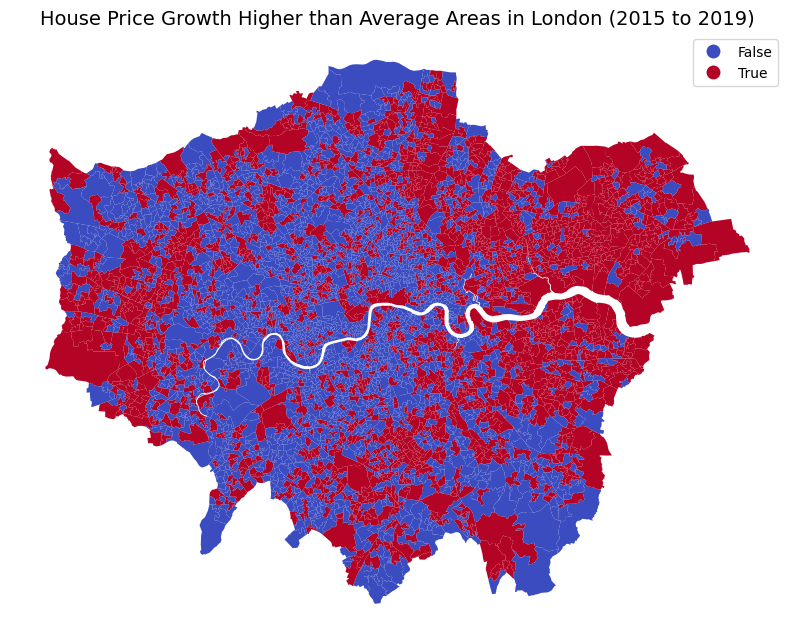

In [52]:
# show high house price areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='high_price_growth', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("House Price Growth Higher than Average Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

As shown in the figure, the areas where house prices rising rate higher than the average are mainly concentrated in the outer London regions, such as East London and West London. The rate of increase in housing prices in the city center is relatively low, possibly because the growth potential is limited or the market itself is already sufficiently saturated.

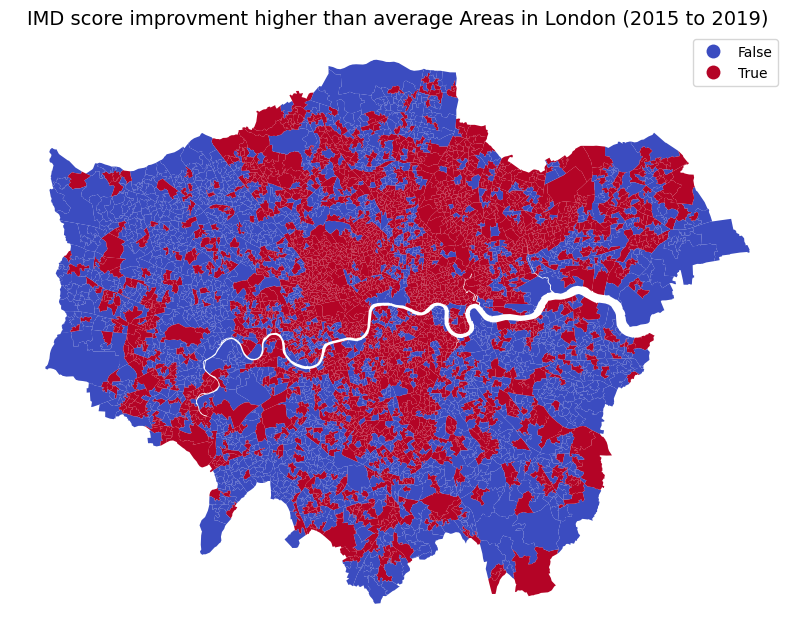

In [53]:
# show High imd scores areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='high_imd_improvment', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("IMD score improvment higher than average Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

However, the regions where the improvement rate of the IMD index was higher than the average were mostly concentrated in the inner London area, showing an opposite trend to the result of house prices.

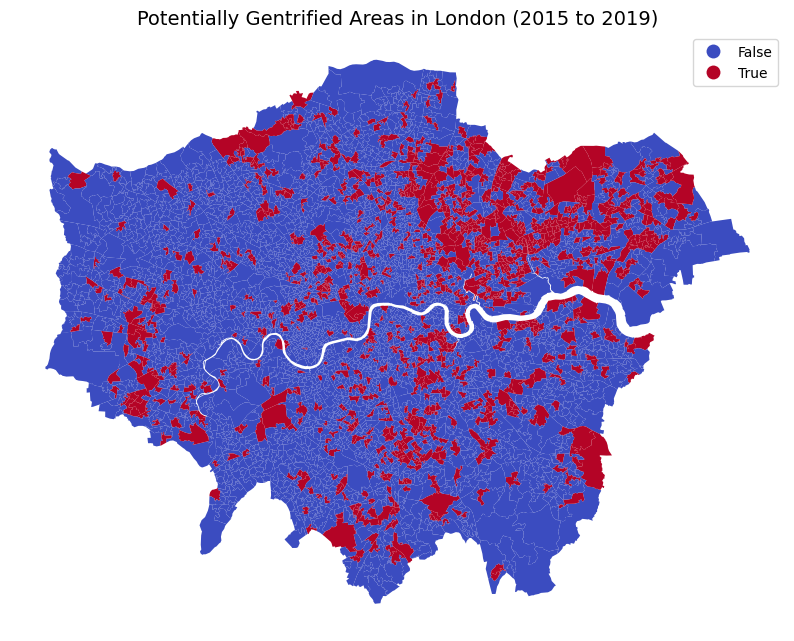

In [54]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='gentrified', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Potentially Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

Based on the results of the previous two graphs, we can see that within the London area, the gentrification phenomenon does not show a centralized trend but is rather scattered and mainly distributed in the surrounding areas outside the core urban area.

In [55]:
london_all_filled.columns

Index(['LSOA code', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry', '2015_filled', '2019_filled',
       'centroid', '2015_final_knn', '2019_final_knn',
       'Index of Multiple Deprivation (IMD) Score_2015', 'LSOA name (2011)',
       'Index of Multiple Deprivation (IMD) Score_2019', 'imd_score_improve',
       'price_growth', 'high_price_growth', 'high_imd_improvment',
       'gentrified'],
      dtype='object')

In [56]:
columns_to_keep = ['LSOA code', 'LSOA11NM', 'geometry',
                   'imd_score_improve', 'price_growth', 
                   'high_price_growth', 'high_imd_improvment', 'gentrified']
london_gentri_labeled = london_all_filled[columns_to_keep]

In [57]:
london_gentri_labeled.to_file("data/gentri_data/london_gentri_labeled.shp")

C:\Users\hp\AppData\Local\Temp\ipykernel_36284\1298374198.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  london_gentri_labeled.to_file("data/gentri_data/london_gentri_labeled.shp")
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'imd_score_improve' to 'imd_score_'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'price_growth' to 'price_grow'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'high_price_growth' to 'high_price'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'high_imd_improvment' to 'hi

In [59]:
# trying for the top 25%

price_growth_75 = london_all_filled['price_growth'].quantile(0.75)
imd_improve_75 = london_all_filled['imd_score_improve'].quantile(0.75)

# add labels for top 25%
london_all_filled['25_price_growth'] = london_all_filled['price_growth'] > price_growth_75
london_all_filled['25_imd_improvement'] = london_all_filled['imd_score_improve'] > imd_improve_75

# specific gentrified
london_all_filled['gentrified2'] = london_all_filled['25_price_growth'] & london_all_filled['25_imd_improvement']
london_all_filled['gentrified2'].value_counts()

gentrified2
False    4568
True      267
Name: count, dtype: int64

In [61]:
columns_to_keep2 = ['LSOA code', 'LSOA11NM', 'geometry',
                   'imd_score_improve', 'price_growth', 
                   'high_price_growth', 'high_imd_improvment', 'gentrified2']
london_gentri_labeled25 = london_all_filled[columns_to_keep2]
london_gentri_labeled25.to_file("data/gentri_data/london_gentri_labeled_25.shp")

C:\Users\hp\AppData\Local\Temp\ipykernel_36284\2809110232.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  london_gentri_labeled25.to_file("data/gentri_data/london_gentri_labeled_25.shp")
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'imd_score_improve' to 'imd_score_'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'price_growth' to 'price_grow'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'high_price_growth' to 'high_price'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'high_imd_improvment' t

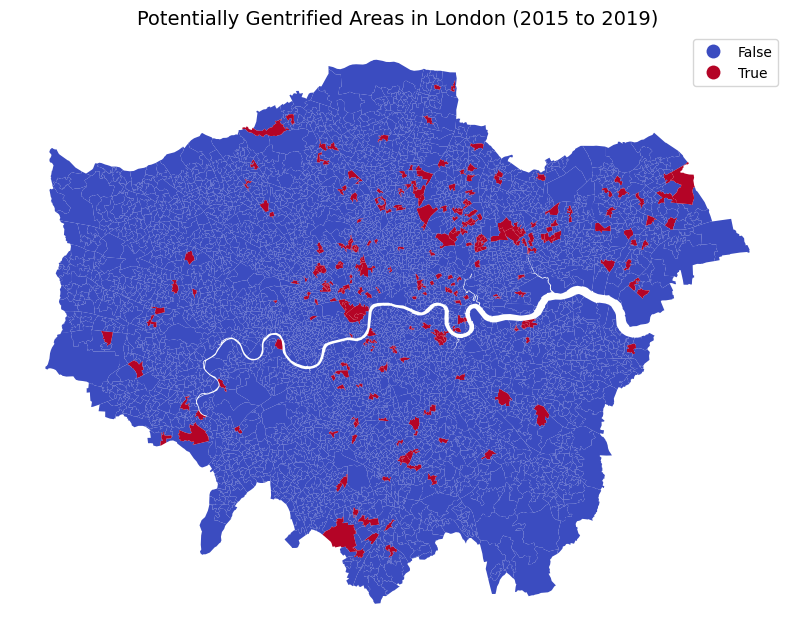

In [60]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='gentrified2', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Potentially Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()